Проанализировать чеки и выявить случаи мошенничества, ненормального поведения клиентов или сотрудников, отклонения. 

In [1]:
import numpy as np
import pandas as pd
import pandasql as ps #library to use sql with pandas df
import matplotlib.pyplot as plt
import seaborn as sns #ploting library
sns.set(style="ticks", color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

# Общий анализ

Получим данные, обработаем их, приведя численные данные к числу с плавающей точкой, также добавим на их основе переменных для дальнейшего анализа.

In [2]:
df = pd.read_csv('data.csv', sep=";")
print(df.shape, "\n")
print(df.columns, "\n")
print(df.info())

(763989, 12) 

Index(['Магазин', 'НомерЧека', 'Дата чека', 'Кол-во', 'Цена', 'Сумма',
       'Серийный Номер', 'Сотрудник', 'Сумма баллов (руб)', 'Бонусная карта',
       'Тип чека', 'strTypeDirr'],
      dtype='object') 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 763989 entries, 0 to 763988
Data columns (total 12 columns):
Магазин               763989 non-null object
НомерЧека             763989 non-null object
Дата чека             763989 non-null object
Кол-во                763989 non-null object
Цена                  763989 non-null object
Сумма                 763989 non-null object
Серийный Номер        763337 non-null object
Сотрудник             763971 non-null object
Сумма баллов (руб)    763989 non-null int64
Бонусная карта        9977 non-null object
Тип чека              763989 non-null object
strTypeDirr           763989 non-null object
dtypes: int64(1), object(11)
memory usage: 69.9+ MB
None


In [3]:
df = df.rename(columns={'Магазин': 'Store', 'НомерЧека': 'Receipt_number','Дата чека': 'Receipt_dt','Кол-во': 'cnt',
                       'Цена': 'Price','Сумма': 'Summa','Серийный Номер': 'Serial_number','Сотрудник': 'Employee',
                       'Сумма баллов (руб)': 'Sum_of_points','Бонусная карта': 'Bonus_card','Тип чека': 'Receipt_type'})

In [4]:
df['Year'] = pd.to_datetime(df['Receipt_dt']).dt.year
df['Month'] = pd.to_datetime(df['Receipt_dt']).dt.month
df['Day'] = pd.to_datetime(df['Receipt_dt']).dt.day
df['Hour'] = pd.to_datetime(df['Receipt_dt']).dt.hour
df['isWorking_hour'] = ((df['Hour'] >= 9) & (df['Hour'] <= 22)).astype(int)
df['Time'] = pd.to_datetime(df['Receipt_dt']).dt.time
df['Date'] = pd.to_datetime(df['Receipt_dt']).dt.date
# the day of the week (Monday=0, Sunday=6) and if it's a week end day or week day.
df['DayOfTheWeek'] = pd.to_datetime(df['Receipt_dt']).dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)

In [5]:
df['cnt'] = df['cnt'].str.replace(',', '.', regex=False)
df['cnt'] = df['cnt'].astype(float)
df['Price'] = df['Price'].str.replace(',', '.', regex=False)
df['Price'] = df['Price'].astype(float)
df['Price_less_zero'] = (df['Price'] < 0).astype(int)
df['Summa'] = df['Summa'].str.replace(',', '.', regex=False)
df['Summa'] = df['Summa'].astype(float)

In [6]:
categorical_columns = [c for c in df.columns if df[c].dtype.name == 'object']
numerical_columns   = [c for c in df.columns if df[c].dtype.name != 'object']
print(categorical_columns)
print(numerical_columns)

['Store', 'Receipt_number', 'Receipt_dt', 'Serial_number', 'Employee', 'Bonus_card', 'Receipt_type', 'strTypeDirr', 'Time', 'Date']
['cnt', 'Price', 'Summa', 'Sum_of_points', 'Year', 'Month', 'Day', 'Hour', 'isWorking_hour', 'DayOfTheWeek', 'WeekDay', 'Price_less_zero']


In [7]:
q1 = """SELECT *,
                 case when strTypeDirr == 'телефон' then 'Телефон' else strTypeDirr end strTypeDirr_right,
                 case when cnt != 1 then 'to_check' else 'ok' end cnt_error
        FROM df
     """
df = ps.sqldf(q1, locals())
df['Time'] = pd.to_datetime(df['Receipt_dt']).dt.time
df['Date'] = pd.to_datetime(df['Receipt_dt']).dt.date

In [8]:
categorical_columns = [c for c in df.columns if df[c].dtype.name == 'object']
numerical_columns   = [c for c in df.columns if df[c].dtype.name != 'object']
print(categorical_columns)
print(numerical_columns)

['Store', 'Receipt_number', 'Receipt_dt', 'Serial_number', 'Employee', 'Bonus_card', 'Receipt_type', 'strTypeDirr', 'Time', 'Date', 'strTypeDirr_right', 'cnt_error']
['cnt', 'Price', 'Summa', 'Sum_of_points', 'Year', 'Month', 'Day', 'Hour', 'isWorking_hour', 'DayOfTheWeek', 'WeekDay', 'Price_less_zero']


Заметим, что большинство операций было совершено в рабочее время, с ценой от 0 до 50000.

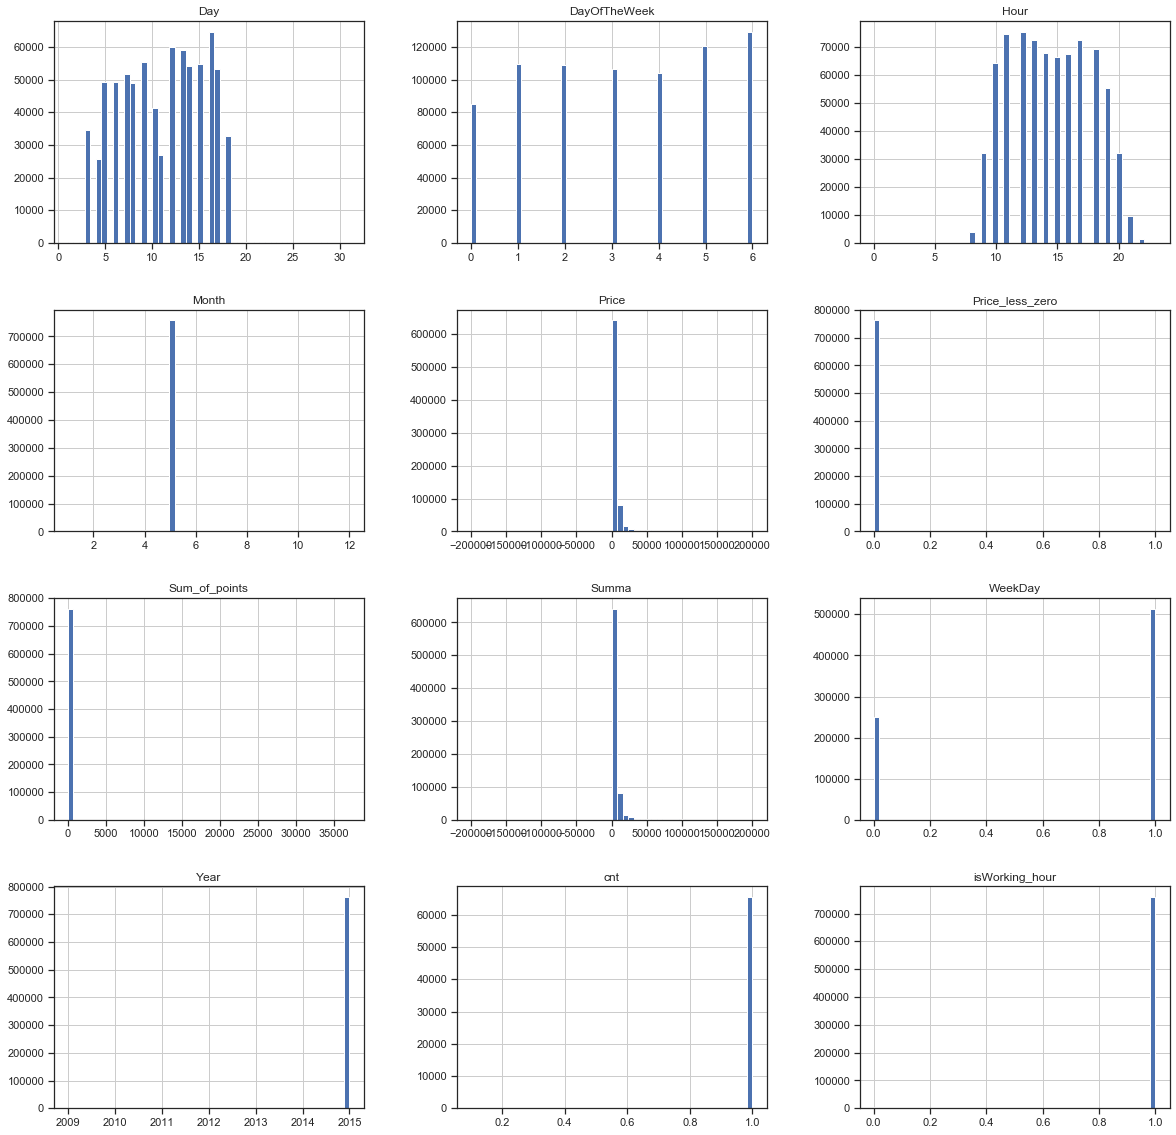

In [9]:
df.hist(bins = 50, figsize = (20,20))
plt.show()

Видно, что датасет дисбалансный. Большинство операций было совершено в 2015. Вдальнейшем мы разделим его на 4 части.

In [11]:
df['Year'].value_counts(normalize=True)

2015    0.998275
2009    0.001296
2014    0.000423
2013    0.000005
2012    0.000001
Name: Year, dtype: float64

We have strTypeDirr with wrong input or are these rows from different source? 

In [12]:
df['strTypeDirr'].value_counts()

Платеж                 749280
Аксессуар                8618
Телефон                  4854
Услуга по настройке       959
телефон                   278
Name: strTypeDirr, dtype: int64

In [13]:
df['Receipt_type'].value_counts()

Продажа    763715
Возврат       274
Name: Receipt_type, dtype: int64

We can see that the most operations are made during work hours(9-22):

In [14]:
df['Hour'].value_counts(normalize=True)

12    0.098594
11    0.097494
13    0.094802
17    0.094709
18    0.090416
14    0.088559
16    0.088374
15    0.086754
10    0.083796
19    0.072290
9     0.042088
20    0.042084
21    0.012704
8     0.005037
22    0.001634
23    0.000137
4     0.000097
0     0.000090
2     0.000079
5     0.000067
1     0.000067
7     0.000062
3     0.000034
6     0.000031
Name: Hour, dtype: float64

Заметим, что датасет можно разделить на 4 части: 
1. 2009 год
2. От 2009 (не влючая) до 2015-04-01
3. С 2015-04-01 по 2015-05-02
4. С 2015-05-02

Посмотрим на частоту операций.

In [15]:
pd.set_option('display.max_rows', df.shape[0]+1)
print(df['Date'].value_counts().sort_index())
pd.set_option('display.max_rows', 50)

2009-04-15       66
2009-04-16      140
2009-04-17      121
2009-04-18      116
2009-04-19       75
2009-04-20       83
2009-04-21       86
2009-04-22      116
2009-04-23       88
2009-04-24       88
2009-04-25       11
2012-01-03        1
2013-05-31        3
2013-08-02        1
2014-01-18        1
2014-02-13        2
2014-02-24        1
2014-03-08        3
2014-03-11        1
2014-03-15        2
2014-03-19        5
2014-03-20        4
2014-03-27        3
2014-03-28        5
2014-03-29       13
2014-03-31        2
2014-04-01        4
2014-04-04        3
2014-04-05        1
2014-04-08        1
2014-04-09        1
2014-04-10        2
2014-04-17       10
2014-04-18        2
2014-04-21        2
2014-04-22        8
2014-04-28        1
2014-05-08        1
2014-05-10        4
2014-05-13        1
2014-05-16        1
2014-05-17        4
2014-05-18        3
2014-05-23        2
2014-05-31        8
2014-06-03        8
2014-06-04        1
2014-06-08        4
2014-06-17        6
2014-06-20        1


# 2009

Most of the returns are in 2009. Lets take a closer look.

In [18]:
df2009 = df.loc[df['Year'] == 2009]

In [19]:
df2009['Receipt_type'].value_counts()

Продажа    717
Возврат    273
Name: Receipt_type, dtype: int64

Очень много операций совершено в нерабочее время.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C39BD1A860>,
      dtype=object)

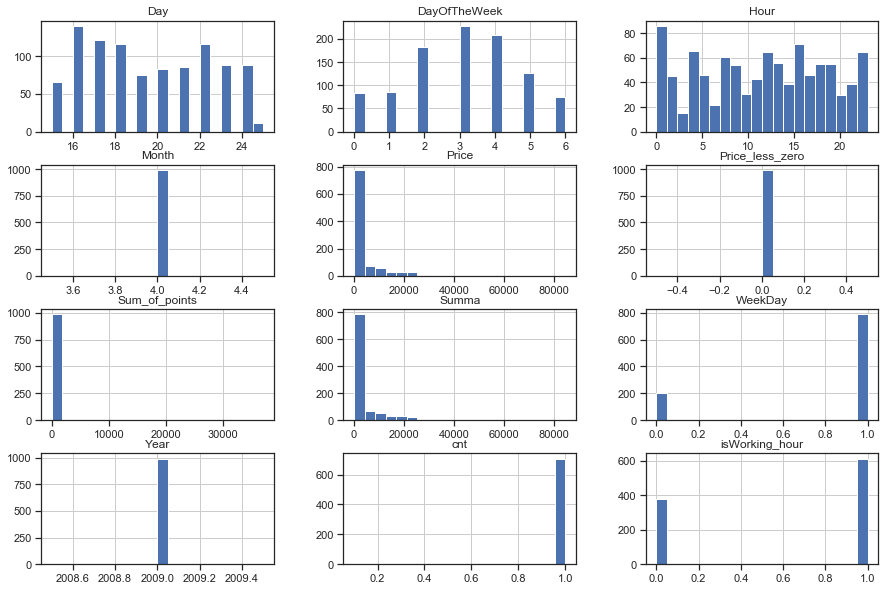

In [20]:
df2009[numerical_columns].hist(figsize=(15,10), bins=20)

Также в 2009 были совершены все ошибки в cnt. Давайте, рассмотрим их.

In [21]:
df2009['cnt'].value_counts()

1.00    706
0.30      1
0.12      1
0.53      1
0.10      1
Name: cnt, dtype: int64

In [22]:
df2009.loc[lambda df2009: df2009['cnt_error'] == 'to_check']

,Store,Receipt_number,Receipt_dt,cnt,Price,Summa,Serial_number,Employee,Sum_of_points,Bonus_card,...,Day,Hour,isWorking_hour,Time,Date,DayOfTheWeek,WeekDay,Price_less_zero,strTypeDirr_right,cnt_error
210407,0x53861306B790E59740A0CAE4B1906D8B,PCRH2030031440,2009-04-16 22:41:20.000,0.12,1990.0,238.8,None,0xF56837EF28088A073F67E9D5437EBE63,0,None,...,16,22,1,22:41:20,2009-04-16,3,1,0,Аксессуар,to_check
214751,0x53861306B790E59740A0CAE4B1906D8B,PCRC7050012158,2009-04-17 15:55:16.000,0.53,990.0,524.7,None,0xF56837EF28088A073F67E9D5437EBE63,0,None,...,17,15,1,15:55:16,2009-04-17,4,1,0,Аксессуар,to_check
220602,0x53861306B790E59740A0CAE4B1906D8B,PCRC6650022757,2009-04-18 06:17:49.000,0.10,2290.0,229.0,None,0xF56837EF28088A073F67E9D5437EBE63,0,None,...,18,6,0,06:17:49,2009-04-18,5,0,0,Аксессуар,to_check
220825,0x53861306B790E59740A0CAE4B1906D8B,PCRP4030021848,2009-04-17 08:28:52.000,0.30,9990.0,2997.0,6251073.0,0xF56837EF28088A073F67E9D5437EBE63,0,None,...,17,8,0,08:28:52,2009-04-17,4,1,0,Телефон,to_check


In [23]:
df2009.loc[lambda df2009: df2009['Employee'] == '0xF56837EF28088A073F67E9D5437EBE63']

,Store,Receipt_number,Receipt_dt,cnt,Price,Summa,Serial_number,Employee,Sum_of_points,Bonus_card,...,Day,Hour,isWorking_hour,Time,Date,DayOfTheWeek,WeekDay,Price_less_zero,strTypeDirr_right,cnt_error
210407,0x53861306B790E59740A0CAE4B1906D8B,PCRH2030031440,2009-04-16 22:41:20.000,0.12,1990.0,238.8,None,0xF56837EF28088A073F67E9D5437EBE63,0,None,...,16,22,1,22:41:20,2009-04-16,3,1,0,Аксессуар,to_check
214751,0x53861306B790E59740A0CAE4B1906D8B,PCRC7050012158,2009-04-17 15:55:16.000,0.53,990.0,524.7,None,0xF56837EF28088A073F67E9D5437EBE63,0,None,...,17,15,1,15:55:16,2009-04-17,4,1,0,Аксессуар,to_check
220602,0x53861306B790E59740A0CAE4B1906D8B,PCRC6650022757,2009-04-18 06:17:49.000,0.10,2290.0,229.0,None,0xF56837EF28088A073F67E9D5437EBE63,0,None,...,18,6,0,06:17:49,2009-04-18,5,0,0,Аксессуар,to_check
220825,0x53861306B790E59740A0CAE4B1906D8B,PCRP4030021848,2009-04-17 08:28:52.000,0.30,9990.0,2997.0,6251073.0,0xF56837EF28088A073F67E9D5437EBE63,0,None,...,17,8,0,08:28:52,2009-04-17,4,1,0,Телефон,to_check
699108,0x53861306B790E59740A0CAE4B1906D8B,PCRH2030031440,2009-04-16 22:41:20.000,NaN,1790.0,1790.0,3006922.0,0xF56837EF28088A073F67E9D5437EBE63,0,None,...,16,22,1,22:41:20,2009-04-16,3,1,0,Телефон,ok


### Почему-то почти все операции сотрудника 0xF56837EF28088A073F67E9D5437EBE63 имеют дробное количество. Также подозрительно то, что он продал телефон и вернул, скорее всего, его же в нерабочее время. Вообще, большинство его операций было в нерабочие часы, что нехарактерно для всей выборки.

В 2009 тип продукта записывался по-другому.

In [25]:
df2009['strTypeDirr'].value_counts()

Аксессуар              667
телефон                278
Услуга по настройке     29
Платеж                  16
Name: strTypeDirr, dtype: int64

In [28]:
pd.set_option('display.max_rows', df.shape[0]+1)
print(df2009[{'Store', 'Employee', 'Receipt_type'}].groupby(['Store', 'Employee', 'Receipt_type']).size())
pd.set_option('display.max_rows', 50)

Store                               Employee                            Receipt_type
0x14466CB7D3B0D9B891CD587D3C30C84B  0x01D4A0E41C9860905184DFA0EE5D9666  Возврат          1
                                    0x0207A5C5BEBB47D243D7E84554802A84  Продажа          1
                                    0x04175944F53CA1852DA75E0D6CE0722F  Возврат          1
                                    0x08CF8E8D67B264AC7CCF7EE0118C4A84  Продажа          3
                                    0x0EBB1AFB8CFA3DB5D2502EE88DB1B96A  Продажа          1
                                    0x1F1402E9413FABAC3118B63D84295076  Возврат          1
                                    0x2380A2A20810F7A1407844865EEF071D  Продажа          1
                                    0x299B2BAF297E6BCE27582D1765D633F0  Возврат          1
                                                                        Продажа          1
                                    0x29B2AE725A3CB3A7169B48F5F9AA1C82  Возврат          1
     

In [30]:
df2009.loc[lambda df: df['Employee'] == '0x5C4D28B735A317E90338CEAF7E0CC0AC']

,Store,Receipt_number,Receipt_dt,cnt,Price,Summa,Serial_number,Employee,Sum_of_points,Bonus_card,...,Day,Hour,isWorking_hour,Time,Date,DayOfTheWeek,WeekDay,Price_less_zero,strTypeDirr_right,cnt_error
55809,0x14466CB7D3B0D9B891CD587D3C30C84B,PCRC3170040010,2009-04-15 12:22:08.000,NaN,2990.0,2990.0,3925666,0x5C4D28B735A317E90338CEAF7E0CC0AC,0,None,...,15,12,1,12:22:08,2009-04-15,2,1,0,Телефон,ok
55814,0x14466CB7D3B0D9B891CD587D3C30C84B,PCRD0570019618,2009-04-25 02:57:40.000,NaN,3990.0,3990.0,4551775,0x5C4D28B735A317E90338CEAF7E0CC0AC,0,None,...,25,2,0,02:57:40,2009-04-25,5,0,0,Телефон,ok
55889,0x14466CB7D3B0D9B891CD587D3C30C84B,PCRS1150021871,2009-04-17 09:01:59.000,NaN,790.0,790.0,None,0x5C4D28B735A317E90338CEAF7E0CC0AC,0,None,...,17,9,1,09:01:59,2009-04-17,4,1,0,Аксессуар,ok
55891,0x14466CB7D3B0D9B891CD587D3C30C84B,PCRS3110013368,2009-04-18 20:57:40.000,NaN,2790.0,2790.0,1724036,0x5C4D28B735A317E90338CEAF7E0CC0AC,0,None,...,18,20,1,20:57:40,2009-04-18,5,0,0,Телефон,ok
56154,0x14466CB7D3B0D9B891CD587D3C30C84B,PCRC2900024865,2009-04-20 08:53:20.000,NaN,1190.0,1190.0,None,0x5C4D28B735A317E90338CEAF7E0CC0AC,0,None,...,20,8,0,08:53:20,2009-04-20,0,1,0,Аксессуар,ok
56162,0x14466CB7D3B0D9B891CD587D3C30C84B,PCRC4930017075,2009-04-22 13:55:44.000,NaN,19990.0,19990.0,0844637,0x5C4D28B735A317E90338CEAF7E0CC0AC,0,None,...,22,13,1,13:55:44,2009-04-22,2,1,0,Телефон,ok
56216,0x14466CB7D3B0D9B891CD587D3C30C84B,PCRS0660022943,2009-04-18 10:45:40.000,NaN,1490.0,1490.0,5917037,0x5C4D28B735A317E90338CEAF7E0CC0AC,0,None,...,18,10,1,10:45:40,2009-04-18,5,0,0,Телефон,ok
56359,0x14466CB7D3B0D9B891CD587D3C30C84B,PCRC4900025530,2009-04-21 00:50:56.000,NaN,6490.0,6490.0,2899232,0x5C4D28B735A317E90338CEAF7E0CC0AC,0,None,...,21,0,0,00:50:56,2009-04-21,1,1,0,Телефон,ok
56383,0x14466CB7D3B0D9B891CD587D3C30C84B,PCRIT090000160,2009-04-15 15:58:08.000,NaN,2990.0,29990.0,1111005,0x5C4D28B735A317E90338CEAF7E0CC0AC,0,None,...,15,15,1,15:58:08,2009-04-15,2,1,0,Телефон,ok
56770,0x14466CB7D3B0D9B891CD587D3C30C84B,PCRC0600015732,2009-04-21 05:41:49.000,NaN,7490.0,7490.0,2082710,0x5C4D28B735A317E90338CEAF7E0CC0AC,250,0x4535B46068CDA8650C7593B7A995489C,...,21,5,0,05:41:49,2009-04-21,1,1,0,Телефон,ok


### Выглядит, будто сотрудник 0x5C4D28B735A317E90338CEAF7E0CC0AC совершал какие-то махинации с возвратом телефонов и аксесуаров в 2009.

Посмотрим на то, какие бонусные карты использовались.

In [33]:
df2009['Bonus_card'].value_counts()

0x4535B46068CDA8650C7593B7A995489C    223
Name: Bonus_card, dtype: int64

In [34]:
df2009[(df2009['Bonus_card'] == '0x4535B46068CDA8650C7593B7A995489C')]

,Store,Receipt_number,Receipt_dt,cnt,Price,Summa,Serial_number,Employee,Sum_of_points,Bonus_card,...,Day,Hour,isWorking_hour,Time,Date,DayOfTheWeek,WeekDay,Price_less_zero,strTypeDirr_right,cnt_error
55812,0x14466CB7D3B0D9B891CD587D3C30C84B,PCRC4930017289,2009-04-22 19:03:54.000,NaN,18990.0,18990.0,0844637,0x2380A2A20810F7A1407844865EEF071D,6400,0x4535B46068CDA8650C7593B7A995489C,...,22,19,1,19:03:54,2009-04-22,2,1,0,Телефон,ok
55839,0x14466CB7D3B0D9B891CD587D3C30C84B,PCRH1910026408,2009-04-21 21:55:16.000,NaN,1790.0,1432.0,None,0x9DEFA0522DC29D332022295B5FD143C6,125,0x4535B46068CDA8650C7593B7A995489C,...,21,21,1,21:55:16,2009-04-21,1,1,0,Аксессуар,ok
55894,0x14466CB7D3B0D9B891CD587D3C30C84B,PCRS3510027319,2009-04-22 19:47:06.000,NaN,24990.0,106.0,0490594,0xFDC8924B25CB854BEF4991586D31E1B2,0,0x4535B46068CDA8650C7593B7A995489C,...,22,19,1,19:47:06,2009-04-22,2,1,0,Телефон,ok
55933,0x14466CB7D3B0D9B891CD587D3C30C84B,PCRY3520012017,2009-04-17 12:32:13.000,NaN,0.0,0.0,None,0xE504FBCEB6C113AF3B321DB0193E9A21,115,0x4535B46068CDA8650C7593B7A995489C,...,17,12,1,12:32:13,2009-04-17,4,1,0,Услуга по настройке,ok
55936,0x14466CB7D3B0D9B891CD587D3C30C84B,PCRY3520012017,2009-04-17 12:32:13.000,NaN,150.0,0.0,None,0xE504FBCEB6C113AF3B321DB0193E9A21,115,0x4535B46068CDA8650C7593B7A995489C,...,17,12,1,12:32:13,2009-04-17,4,1,0,Аксессуар,ok
55943,0x14466CB7D3B0D9B891CD587D3C30C84B,PCRY3520012017,2009-04-17 12:32:13.000,NaN,3390.0,3390.0,4171980,0xE504FBCEB6C113AF3B321DB0193E9A21,115,0x4535B46068CDA8650C7593B7A995489C,...,17,12,1,12:32:13,2009-04-17,4,1,0,Телефон,ok
56186,0x14466CB7D3B0D9B891CD587D3C30C84B,PCRD0570019619,2009-04-25 02:59:06.000,NaN,3290.0,3290.0,4551775,0x73A622BB9940B3C658413C939A3F8224,110,0x4535B46068CDA8650C7593B7A995489C,...,25,2,0,02:59:06,2009-04-25,5,0,0,Телефон,ok
56196,0x14466CB7D3B0D9B891CD587D3C30C84B,PCRP0650018056,2009-04-23 13:28:23.000,NaN,150.0,0.0,None,0x08CF8E8D67B264AC7CCF7EE0118C4A84,120,0x4535B46068CDA8650C7593B7A995489C,...,23,13,1,13:28:23,2009-04-23,3,1,0,Аксессуар,ok
56197,0x14466CB7D3B0D9B891CD587D3C30C84B,PCRP7100007206,2009-04-22 17:04:23.000,NaN,1490.0,1192.0,5813046,0xF10ED018F4974EDB5752149C9E2A234A,400,0x4535B46068CDA8650C7593B7A995489C,...,22,17,1,17:04:23,2009-04-22,2,1,0,Телефон,ok
56265,0x14466CB7D3B0D9B891CD587D3C30C84B,PCRY0650034184,2009-04-19 16:32:42.000,NaN,570.0,1.0,None,0x357F8FC88DDA1EA79D17907A29A63681,20,0x4535B46068CDA8650C7593B7A995489C,...,19,16,1,16:32:42,2009-04-19,6,0,0,Аксессуар,ok


### Похоже, имел случай набора бонусов на какую-то бонусную карту, возможно, просто тестировалась система бонусов - точно сказать не могу.

# От 2009 (не влючая) до 2015-04-01.

In [37]:
date20150401 = datetime.strptime('2015-04-01', '%Y-%m-%d').date()
df20150401 = df.loc[(df['Date'] < date20150401) & (df['Year'] > 2009)]

In [38]:
df20150401

,Store,Receipt_number,Receipt_dt,cnt,Price,Summa,Serial_number,Employee,Sum_of_points,Bonus_card,...,Day,Hour,isWorking_hour,Time,Date,DayOfTheWeek,WeekDay,Price_less_zero,strTypeDirr_right,cnt_error
425,0x000E60053B20A6166262BC589F5C1D1A,PCRC11126907,2015-01-09 11:05:10.800,NaN,0.0,0.0,0,0xA885403AF8E2D165A7C57209F172349E,0,None,...,9,11,1,11:05:10.800000,2015-01-09,4,1,0,Аксессуар,ok
461,0x000E60053B20A6166262BC589F5C1D1A,PCRC11126907,2015-01-09 11:05:10.800,NaN,2990.0,2690.0,9302412,0xA885403AF8E2D165A7C57209F172349E,0,None,...,9,11,1,11:05:10.800000,2015-01-09,4,1,0,Телефон,ok
2515,0x00AD2513E247F17DCA036BCE670EB230,PCRC40103460,2015-03-25 22:26:51.800,NaN,1899.0,1899.0,0,0xF2E171AC0ABF4A752E7D5B451B4A9B95,0,None,...,25,22,1,22:26:51.800000,2015-03-25,2,1,0,Услуга по настройке,ok
2641,0x00AD2513E247F17DCA036BCE670EB230,PCRC40103460,2015-03-25 22:26:51.800,NaN,16990.0,16990.0,2934847,0xF2E171AC0ABF4A752E7D5B451B4A9B95,0,None,...,25,22,1,22:26:51.800000,2015-03-25,2,1,0,Телефон,ok
2704,0x00AD2513E247F17DCA036BCE670EB230,PCRC40103460,2015-03-25 22:26:51.800,NaN,299.0,299.0,0,0xF2E171AC0ABF4A752E7D5B451B4A9B95,0,None,...,25,22,1,22:26:51.800000,2015-03-25,2,1,0,Телефон,ok
3259,0x00B782B2C42F79F010423D8B3A93ED5E,PCRC30501949,2015-01-21 17:29:21.800,NaN,2990.0,2690.0,9273346,0x90D9480779B0AEC31DBD196B2865B12A,0,None,...,21,17,1,17:29:21.800000,2015-01-21,2,1,0,Телефон,ok
3482,0x00B782B2C42F79F010423D8B3A93ED5E,PCRC30501949,2015-01-21 17:29:21.800,NaN,0.0,0.0,0,0x90D9480779B0AEC31DBD196B2865B12A,0,None,...,21,17,1,17:29:21.800000,2015-01-21,2,1,0,Аксессуар,ok
7106,0x02A1883A72C7DB441E4BDE4020EEA501,PCRC11054155,2014-04-05 16:53:51.800,NaN,14990.0,10940.0,4476937,0x5806CAA502288F5CB9A2DE9F67AE0841,0,None,...,5,16,1,16:53:51.800000,2014-04-05,5,0,0,Телефон,ok
20084,0x08429DB8F304053FB447098835FE8BCB,PCRC50709142,2015-03-26 17:35:30.800,NaN,300.0,300.0,0,0xD3C6096AC62B822BEE487BBF07137B0A,0,None,...,26,17,1,17:35:30.800000,2015-03-26,3,1,0,Услуга по настройке,ok
24291,0x09B2B5FDB45D87626AE42A665A72358F,PCRC20106160,2015-01-14 17:15:56.800,NaN,690.0,690.0,0,0xE7C2C48140C6A3ADDF9A4D7013ACB312,35,0x73ED1372D31DF8BC83874A1E028FCBB8,...,14,17,1,17:15:56.800000,2015-01-14,2,1,0,Телефон,ok


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C4409D0F98>,
      dtype=object)

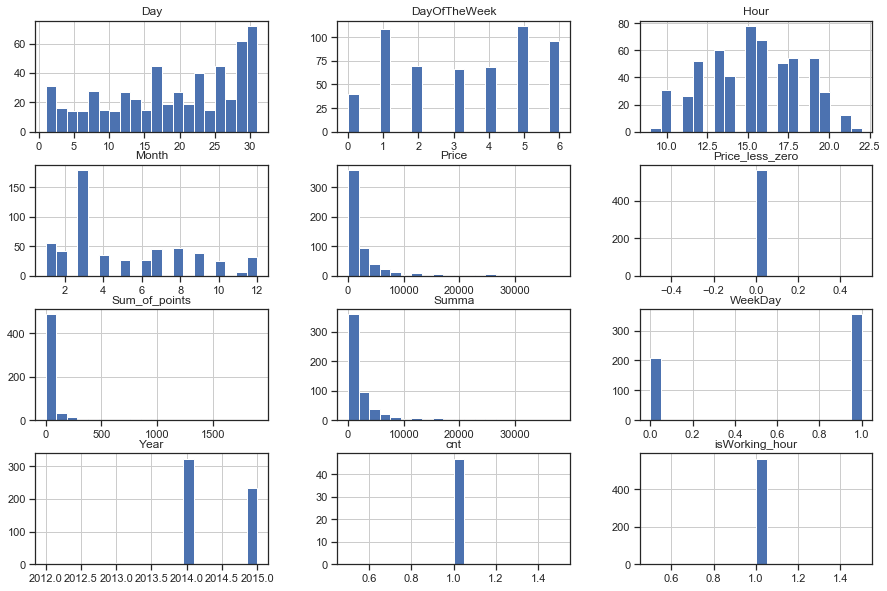

In [39]:
df20150401[numerical_columns].hist(figsize=(15,10), bins=20)

In [40]:
df20150401['Store'].value_counts()

0x2C3CCFA096CAD4EEAE2CFF1531184D4A    13
0x4B9B77B49C8A40B4645C3391487CC7D5    11
0x09B2B5FDB45D87626AE42A665A72358F     9
0x108897D16B4CE5DA4C78A97CB273D5E4     8
0xE891AD43035D7938365B8500EA162E70     8
0xD5E296BAA954B400DAB868461C9DE084     7
0x9C7BD938EC12DBA6155157D98AE0E773     7
0xE989EE147BB5E75ED8EF6E7C5C150DF5     6
0xCE5BE57D800B59597A0CC2365F877317     6
0xBD148B6B8FE97417A49004665DB10A00     6
0x6BCA9A1393A80F1A7C1D1EC807304087     6
0x5524E3F99A352D30334F15D80E218D9D     6
0x1A6F7679F1AC6C363A3E051CC96B229B     6
0x379EA608A300B6C3F0723DD9C6249304     6
0xC0D27FF723593A3679368FD08AB1FFE3     6
0x95E910A63CCF10AE72ABF96F10209158     5
0x1910594D047396EFBB7DDEC34E36375C     5
0x5EB45FCFA2FBB5A8B2EC5D3C4F026C98     5
0x0D3158C65BA28AF77A3E91A7FCB2A049     5
0x95EC253143A031B3C6D534BC5490D260     5
0x4D426C91865059255205C0375EF0B833     5
0x2555EF113D1B077C39ABBA43148530F2     5
0xA4A1CC563745153B2D0F49FAF2E95452     5
0xB416374873BDC34FAB36EC64A8381EFC     5
0x96E97D6600608A

In [41]:
df20150401['strTypeDirr'].value_counts()

Телефон                306
Аксессуар              140
Услуга по настройке     86
Платеж                  30
Name: strTypeDirr, dtype: int64

In [42]:
df20150401['Employee'].nunique()

252

In [43]:
df20150401['Store'].nunique()

216

In [44]:
df20150401.loc[lambda df20150401: df20150401['Store'] == '0x2C3CCFA096CAD4EEAE2CFF1531184D4A']

,Store,Receipt_number,Receipt_dt,cnt,Price,Summa,Serial_number,Employee,Sum_of_points,Bonus_card,...,Day,Hour,isWorking_hour,Time,Date,DayOfTheWeek,WeekDay,Price_less_zero,strTypeDirr_right,cnt_error
116166,0x2C3CCFA096CAD4EEAE2CFF1531184D4A,PCRC11041668,2014-04-22 13:23:47.800,NaN,0.0,0.0,0,0x69D9E9DFB3BA1FB49CF4510B55818D7F,0,0xD2DAA683FD2C927B161E7EECA347A8D9,...,22,13,1,13:23:47.800000,2014-04-22,1,1,0,Аксессуар,ok
116174,0x2C3CCFA096CAD4EEAE2CFF1531184D4A,PCRC11041668,2014-04-22 13:23:47.800,NaN,50.0,50.0,0,0x445B2EC9947D3F7333F7A8A8CCA6227D,3,0xD2DAA683FD2C927B161E7EECA347A8D9,...,22,13,1,13:23:47.800000,2014-04-22,1,1,0,Платеж,ok
116176,0x2C3CCFA096CAD4EEAE2CFF1531184D4A,PCRC11041668,2014-04-22 13:23:47.800,NaN,3290.0,3015.0,9301348,0x69D9E9DFB3BA1FB49CF4510B55818D7F,151,0xD2DAA683FD2C927B161E7EECA347A8D9,...,22,13,1,13:23:47.800000,2014-04-22,1,1,0,Телефон,ok
116177,0x2C3CCFA096CAD4EEAE2CFF1531184D4A,PCRC11043826,2015-01-12 15:06:21.800,NaN,0.0,0.0,0,0x36D8F6374D63C4C298B8BFD86F947B81,0,0x8E4B36CE605DB94F2C9548B39E94756D,...,12,15,1,15:06:21.800000,2015-01-12,0,1,0,Аксессуар,ok
117351,0x2C3CCFA096CAD4EEAE2CFF1531184D4A,PCRC11041668,2014-04-22 13:23:47.800,NaN,299.0,299.0,0,0x69D9E9DFB3BA1FB49CF4510B55818D7F,15,0xD2DAA683FD2C927B161E7EECA347A8D9,...,22,13,1,13:23:47.800000,2014-04-22,1,1,0,Телефон,ok
117357,0x2C3CCFA096CAD4EEAE2CFF1531184D4A,PCRC11041668,2014-04-22 13:23:47.800,NaN,499.0,499.0,0,0x69D9E9DFB3BA1FB49CF4510B55818D7F,25,0xD2DAA683FD2C927B161E7EECA347A8D9,...,22,13,1,13:23:47.800000,2014-04-22,1,1,0,Телефон,ok
117360,0x2C3CCFA096CAD4EEAE2CFF1531184D4A,PCRC11043826,2015-01-12 15:06:21.800,NaN,299.0,299.0,0,0x36D8F6374D63C4C298B8BFD86F947B81,15,0x8E4B36CE605DB94F2C9548B39E94756D,...,12,15,1,15:06:21.800000,2015-01-12,0,1,0,Телефон,ok
117365,0x2C3CCFA096CAD4EEAE2CFF1531184D4A,PCRC11043826,2015-01-12 15:06:21.800,NaN,1499.0,1499.0,0,0x36D8F6374D63C4C298B8BFD86F947B81,75,0x8E4B36CE605DB94F2C9548B39E94756D,...,12,15,1,15:06:21.800000,2015-01-12,0,1,0,Услуга по настройке,ok
119126,0x2C3CCFA096CAD4EEAE2CFF1531184D4A,PCRC11043826,2015-01-12 15:06:21.800,NaN,1059.0,1059.0,0,0x36D8F6374D63C4C298B8BFD86F947B81,53,0x8E4B36CE605DB94F2C9548B39E94756D,...,12,15,1,15:06:21.800000,2015-01-12,0,1,0,Услуга по настройке,ok
120135,0x2C3CCFA096CAD4EEAE2CFF1531184D4A,PCRC11041668,2014-04-22 13:23:47.800,NaN,0.0,0.0,0,0x69D9E9DFB3BA1FB49CF4510B55818D7F,0,0xD2DAA683FD2C927B161E7EECA347A8D9,...,22,13,1,13:23:47.800000,2014-04-22,1,1,0,Услуга по настройке,ok


In [45]:
df20150401[(df20150401['Price'] > 20000) ]

,Store,Receipt_number,Receipt_dt,cnt,Price,Summa,Serial_number,Employee,Sum_of_points,Bonus_card,...,Day,Hour,isWorking_hour,Time,Date,DayOfTheWeek,WeekDay,Price_less_zero,strTypeDirr_right,cnt_error
75204,0x1A22D6D48D15BC19A164AB85AF9A8783,PCRC4010963,2014-09-15 12:42:54.800,NaN,22990.0,22990.00,5416952,0x648D34AA248FE40D460A9BADB55E6039,1150,0x8D53471E59719FCD77978BBCB29285E5,...,15,12,1,12:42:54.800000,2014-09-15,0,1,0,Телефон,ok
143505,0x35714B7454759B90D5795D6C0DCF9440,PCRC40404972,2014-07-01 18:53:00.800,NaN,22856.0,22856.00,634903,0x55167ED34013889C4BA0EFDE5B091ADC,1143,0x72D97254B43ED8F7C5130624D230F3F2,...,1,18,1,18:53:00.800000,2014-07-01,1,1,0,Телефон,ok
199499,0x4D7321012F543C1A226B593B5DDBCBE1,PCRC7030975,2014-10-22 13:13:43.800,1.0,23391.0,23391.00,944176.0,0x67BF8ED94B550C37589DE108508E5B94,0,None,...,22,13,1,13:13:43.800000,2014-10-22,2,1,0,Телефон,ok
238382,0x596C20EA20FEFA6DA11C39F66B9E3292,PCRC50918226,2015-03-19 14:46:13.800,1.0,25210.0,25210.00,7120110.0,0xED8E1E5136DD9092277B65785DF9D611,0,None,...,19,14,1,14:46:13.800000,2015-03-19,3,1,0,Телефон,ok
338026,0x828DA277CB6270FF4312A6AADF4D06C4,PCRC10209128,2014-05-13 20:57:48.800,NaN,24990.0,20420.00,263532,0xCBD1240BC1806A06A0B35C1C65AFB49C,0,None,...,13,20,1,20:57:48.800000,2014-05-13,1,1,0,Телефон,ok
362306,0x8EEC48088441F7B23792558446689093,PCRC50201916,2015-03-31 14:02:41.800,NaN,24990.0,22002.29,9167015,0xC7F15857A93A7BC0E4DA53737C024A1F,1100,0x004D2EC74A52145AED4329B3533DE3BF,...,31,14,1,14:02:41.800000,2015-03-31,1,1,0,Телефон,ok
379664,0x943D423120CB1992A2D5F8844C06C5A5,PCRC10206818,2015-03-22 12:24:40.800,NaN,35990.0,35989.00,5976484,0x5E16147E2E3BC2AACB099308187FC7D7,1799,0x2820DBAD0093938A936DB1F0DE0DFC75,...,22,12,1,12:24:40.800000,2015-03-22,6,0,0,Телефон,ok
409690,0x987645A0FF8AD9EF3338359E26D939F7,PCRC30509256,2014-07-27 18:14:35.800,NaN,24990.0,22001.95,2688260,0x013E9DAB11FB3744AC13DA0C5CB9CF98,0,None,...,27,18,1,18:14:35.800000,2014-07-27,6,0,0,Телефон,ok
593441,0xE245A6BB37DD7E049640F173A78739E1,PCRC10201628,2015-02-17 18:12:56.800,NaN,25388.0,25388.00,0,0x5F0615CE7E7A15300B17669AFDA0045A,1269,0x18DF6F0CFC07009E20BF7CAC43AD130E,...,17,18,1,18:12:56.800000,2015-02-17,1,1,0,Телефон,ok
681378,0x221C1BC481D4C17ACD1E0681BECAD6A1,PCRC10209029,2014-05-16 16:51:11.800,NaN,32990.0,30940.00,4050005.0,0x6C87CA05CE3D2A4305C842058341AB29,0,None,...,16,16,1,16:51:11.800000,2014-05-16,4,1,0,Телефон,ok


In [46]:
df20150401['Bonus_card'].value_counts()

0xD2DAA683FD2C927B161E7EECA347A8D9    8
0x9848A62B7DA177FA186E89ED2D49E28B    8
0x73ED1372D31DF8BC83874A1E028FCBB8    7
0xB98ED03F3E7218A56AE619E4B55312EF    6
0xDC81B1D3B52FC37F23094D167CF0BC74    6
0x031D351532E1F215D5C39AF39010DC76    6
0x8E4B36CE605DB94F2C9548B39E94756D    5
0xD8750495B3D69903AC92422DAA893D1E    5
0x01D581AA203AAB9ACC5DF9027D1D8BC5    5
0x3DEC19FF7D9C083A580843B3F6A30317    5
0x372E00E3862815AF0F98D0001FA3F3A1    4
0x0EA96FCA20FD86B5EE00617E5B72FD2A    4
0x65043EF15F2E8482286C1BAFFF978226    4
0x004D2EC74A52145AED4329B3533DE3BF    4
0x46D0EB612AA9CBC2B533C7B5CD921E82    4
0x0AAF420144AC2FCAFE8D107DF6ADEA50    4
0x6AD67FE98F02A1A190773AF4F271CC4A    4
0x186AEF94DE27AE4EC204AC1262DA28EE    4
0xE08B153B1F829004E50F64FE50FF9373    4
0x3BC6F1F8BCD23BCC6AEC26E7DF6444D1    4
0x3644AE2304B4D3D96FCB7C5753C2521C    4
0xDF3CCF3BA5444C45A823A5E23EAF713C    4
0x860F7680D58D81269B8F2E19AC607B6B    4
0x694EDDE73A0E689C5043FCE2FDCE5DB7    3
0x18DF6F0CFC07009E20BF7CAC43AD130E    3


Ничего интересного за этот период не вижу.

# C 2015-04-01 по 2015-05-02

In [47]:
date20150502 = datetime.strptime('2015-05-02', '%Y-%m-%d').date()
df20150502 = df.loc[(df['Date'] >= date20150401) & (df['Date'] <= date20150502)]

In [48]:
df20150502

,Store,Receipt_number,Receipt_dt,cnt,Price,Summa,Serial_number,Employee,Sum_of_points,Bonus_card,...,Day,Hour,isWorking_hour,Time,Date,DayOfTheWeek,WeekDay,Price_less_zero,strTypeDirr_right,cnt_error
71,0x0001C9CA7CDB25F0A9D987C8FC5D6EF8,PCRC80807527,2015-04-08 12:52:47.800,NaN,2490.0,2490.00,0,0x574599751BAE59275C2542A11D32D7FB,0,None,...,8,12,1,12:52:47.800000,2015-04-08,2,1,0,Аксессуар,ok
89,0x0001C9CA7CDB25F0A9D987C8FC5D6EF8,PCRC80807527,2015-04-08 12:52:47.800,NaN,999.0,999.00,0,0x574599751BAE59275C2542A11D32D7FB,0,None,...,8,12,1,12:52:47.800000,2015-04-08,2,1,0,Услуга по настройке,ok
100,0x0001C9CA7CDB25F0A9D987C8FC5D6EF8,PCRC80807527,2015-04-08 12:52:47.800,NaN,22.0,22.00,0,0x574599751BAE59275C2542A11D32D7FB,0,None,...,8,12,1,12:52:47.800000,2015-04-08,2,1,0,Платеж,ok
122,0x0001C9CA7CDB25F0A9D987C8FC5D6EF8,PCRC80807946,2015-04-18 11:48:03.800,NaN,450.0,450.00,0,0x08AAF9811BF20CD7709854F825B2F027,0,None,...,18,11,1,11:48:03.800000,2015-04-18,5,0,0,Аксессуар,ok
128,0x0001C9CA7CDB25F0A9D987C8FC5D6EF8,PCRC80807946,2015-04-18 11:48:03.800,NaN,1199.0,1199.00,0,0x08AAF9811BF20CD7709854F825B2F027,0,None,...,18,11,1,11:48:03.800000,2015-04-18,5,0,0,Услуга по настройке,ok
176,0x0001C9CA7CDB25F0A9D987C8FC5D6EF8,PCRC80807527,2015-04-08 12:52:47.800,NaN,3490.0,3490.00,6623030,0x574599751BAE59275C2542A11D32D7FB,0,None,...,8,12,1,12:52:47.800000,2015-04-08,2,1,0,Телефон,ok
181,0x0001C9CA7CDB25F0A9D987C8FC5D6EF8,PCRC80807527,2015-04-08 12:52:47.800,NaN,1199.0,1199.00,0,0x574599751BAE59275C2542A11D32D7FB,0,None,...,8,12,1,12:52:47.800000,2015-04-08,2,1,0,Услуга по настройке,ok
188,0x0001C9CA7CDB25F0A9D987C8FC5D6EF8,PCRC80807596,2015-04-10 10:19:19.800,NaN,3490.0,3490.00,6623030,0x574599751BAE59275C2542A11D32D7FB,0,None,...,10,10,1,10:19:19.800000,2015-04-10,4,1,0,Телефон,ok
190,0x0001C9CA7CDB25F0A9D987C8FC5D6EF8,PCRC80807946,2015-04-18 11:48:03.800,NaN,50.0,50.00,0,0x08AAF9811BF20CD7709854F825B2F027,0,None,...,18,11,1,11:48:03.800000,2015-04-18,5,0,0,Платеж,ok
194,0x0001C9CA7CDB25F0A9D987C8FC5D6EF8,PCRC80807946,2015-04-18 11:48:03.800,NaN,0.0,0.00,0,0x08AAF9811BF20CD7709854F825B2F027,0,None,...,18,11,1,11:48:03.800000,2015-04-18,5,0,0,Аксессуар,ok


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C41D27D470>,
      dtype=object)

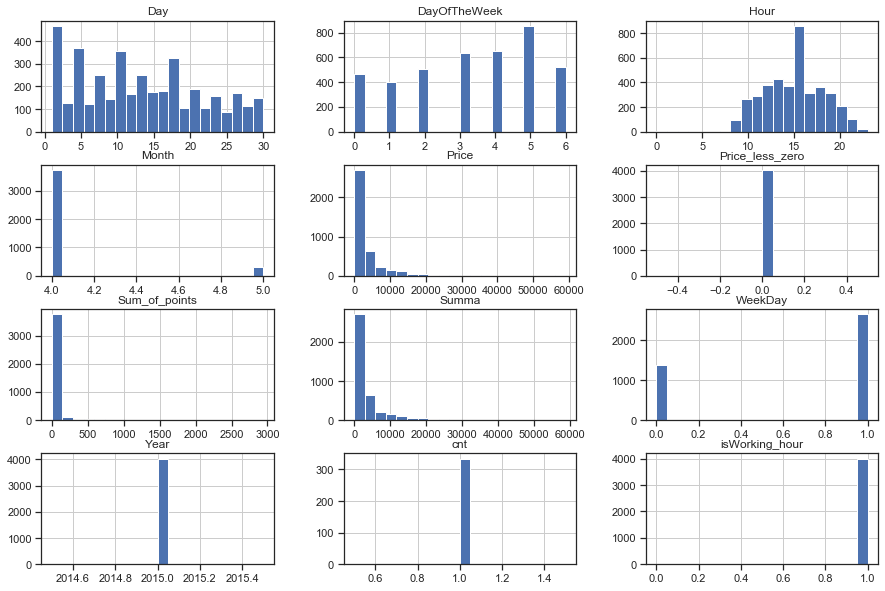

In [60]:
df20150502[numerical_columns].hist(figsize=(15,10), bins=20)

Ничего интересного за этот период не вижу.

# C 2015-05-02

In [50]:
dffrom20150502 = df.loc[(df['Date'] >= date20150502)]

In [51]:
dffrom20150502

,Store,Receipt_number,Receipt_dt,cnt,Price,Summa,Serial_number,Employee,Sum_of_points,Bonus_card,...,Day,Hour,isWorking_hour,Time,Date,DayOfTheWeek,WeekDay,Price_less_zero,strTypeDirr_right,cnt_error
0,0x00003DF3FDACC72FD85F505BCCE8377A,PCRC11198839,2015-05-03 11:04:16.800,NaN,2579.00,2579.00,0,0xB6FB1975EE439EA5CD19A5A96AD16F6D,0,None,...,3,11,1,11:04:16.800000,2015-05-03,6,0,0,Платеж,ok
1,0x00003DF3FDACC72FD85F505BCCE8377A,PCRC11198880,2015-05-03 19:25:16.800,NaN,63000.00,63000.00,0,0x779266FA890AE3707AAD3FAC8D740DD0,0,None,...,3,19,1,19:25:16.800000,2015-05-03,6,0,0,Платеж,ok
2,0x00003DF3FDACC72FD85F505BCCE8377A,PCRC11198973,2015-05-05 18:05:16.800,NaN,0.00,0.00,0,0xB0587EA47B000DE3B267B4318BD6C854,0,None,...,5,18,1,18:05:16.800000,2015-05-05,1,1,0,Аксессуар,ok
3,0x00003DF3FDACC72FD85F505BCCE8377A,PCRC11198896,2015-05-04 11:00:16.800,NaN,5050.00,5050.00,0,0xB6FB1975EE439EA5CD19A5A96AD16F6D,0,None,...,4,11,1,11:00:16.800000,2015-05-04,0,1,0,Платеж,ok
4,0x00003DF3FDACC72FD85F505BCCE8377A,PCRC11198871,2015-05-03 17:12:16.800,NaN,1300.00,1300.00,0,0xB0587EA47B000DE3B267B4318BD6C854,0,None,...,3,17,1,17:12:16.800000,2015-05-03,6,0,0,Платеж,ok
5,0x00003DF3FDACC72FD85F505BCCE8377A,PCRC11198966,2015-05-05 16:27:16.800,NaN,3000.00,3000.00,0,0x42FB6A5213FCC446511AE787B486ABE6,0,None,...,5,16,1,16:27:16.800000,2015-05-05,1,1,0,Платеж,ok
6,0x00003DF3FDACC72FD85F505BCCE8377A,PCRC11199023,2015-05-06 18:21:16.800,NaN,9777.81,9777.81,0,0x42FB6A5213FCC446511AE787B486ABE6,0,None,...,6,18,1,18:21:16.800000,2015-05-06,2,1,0,Платеж,ok
7,0x00003DF3FDACC72FD85F505BCCE8377A,PCRC11198922,2015-05-04 15:51:16.800,NaN,1850.00,1850.00,0,0x42FB6A5213FCC446511AE787B486ABE6,0,None,...,4,15,1,15:51:16.800000,2015-05-04,0,1,0,Платеж,ok
8,0x00003DF3FDACC72FD85F505BCCE8377A,PCRC11198952,2015-05-05 13:59:16.800,NaN,4000.00,4000.00,0,0x42FB6A5213FCC446511AE787B486ABE6,0,None,...,5,13,1,13:59:16.800000,2015-05-05,1,1,0,Платеж,ok
9,0x00003DF3FDACC72FD85F505BCCE8377A,PCRC11198959,2015-05-05 14:42:16.800,NaN,3600.00,3600.00,0,0xB0587EA47B000DE3B267B4318BD6C854,0,None,...,5,14,1,14:42:16.800000,2015-05-05,1,1,0,Платеж,ok


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C447215A90>,
      dtype=object)

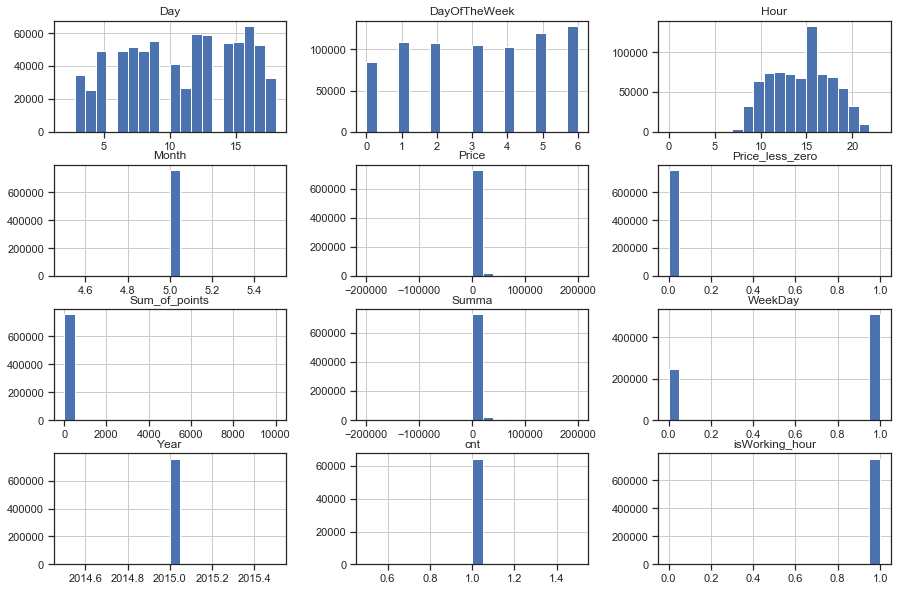

In [52]:
dffrom20150502[numerical_columns].hist(figsize=(15,10), bins=20)

In [53]:
dffrom20150502[dffrom20150502['isWorking_hour'] < 1]

,Store,Receipt_number,Receipt_dt,cnt,Price,Summa,Serial_number,Employee,Sum_of_points,Bonus_card,...,Day,Hour,isWorking_hour,Time,Date,DayOfTheWeek,WeekDay,Price_less_zero,strTypeDirr_right,cnt_error
458,0x0045210B3169C431E5AEA4C9BE84A4E3,PCRC11042087,2015-05-06 08:42:16.800,NaN,7400.00,7400.00,0,0xFD455FCC6A3592383590D79CADA1B53B,0,None,...,6,8,0,08:42:16.800000,2015-05-06,2,1,0,Платеж,ok
520,0x0045210B3169C431E5AEA4C9BE84A4E3,PCRC11042479,2015-05-12 08:22:16.800,NaN,2850.00,2850.00,0,0x5D2EA50465C912B56A2E3639774DD773,0,None,...,12,8,0,08:22:16.800000,2015-05-12,1,1,0,Платеж,ok
598,0x0045210B3169C431E5AEA4C9BE84A4E3,PCRC11042783,2015-05-16 08:22:16.800,NaN,2950.00,2950.00,0,0xE8AC8C0775CD7FF59D3AE93F40D2FF58,0,None,...,16,8,0,08:22:16.800000,2015-05-16,5,0,0,Платеж,ok
601,0x0045210B3169C431E5AEA4C9BE84A4E3,PCRC11042168,2015-05-07 08:54:16.800,NaN,9700.00,9700.00,0,0xFD455FCC6A3592383590D79CADA1B53B,0,None,...,7,8,0,08:54:16.800000,2015-05-07,3,1,0,Платеж,ok
603,0x0045210B3169C431E5AEA4C9BE84A4E3,PCRC11042788,2015-05-16 08:55:16.800,NaN,2050.00,2050.00,0,0x5D2EA50465C912B56A2E3639774DD773,103,0xD08A1535B16B5927CC3231185DE4670B,...,16,8,0,08:55:16.800000,2015-05-16,5,0,0,Платеж,ok
619,0x0045210B3169C431E5AEA4C9BE84A4E3,PCRC11041916,2015-05-03 08:54:16.800,NaN,1600.00,1600.00,0,0x0E9DC213F70EB03FF77E2C00AF257DE4,0,None,...,3,8,0,08:54:16.800000,2015-05-03,6,0,0,Платеж,ok
627,0x0045210B3169C431E5AEA4C9BE84A4E3,PCRC11041978,2015-05-04 08:44:16.800,NaN,3300.00,3300.00,0,0x5D2EA50465C912B56A2E3639774DD773,0,None,...,4,8,0,08:44:16.800000,2015-05-04,0,1,0,Платеж,ok
655,0x0045210B3169C431E5AEA4C9BE84A4E3,PCRC11042167,2015-05-07 08:35:16.800,NaN,1550.00,1550.00,0,0xFD455FCC6A3592383590D79CADA1B53B,0,None,...,7,8,0,08:35:16.800000,2015-05-07,3,1,0,Платеж,ok
656,0x0045210B3169C431E5AEA4C9BE84A4E3,PCRC11042406,2015-05-11 08:20:16.800,NaN,1980.00,1980.00,0,0x5D2EA50465C912B56A2E3639774DD773,0,None,...,11,8,0,08:20:16.800000,2015-05-11,0,1,0,Платеж,ok
686,0x0045210B3169C431E5AEA4C9BE84A4E3,PCRC11042550,2015-05-13 08:38:16.800,NaN,2200.00,2200.00,0,0xFD455FCC6A3592383590D79CADA1B53B,0,None,...,13,8,0,08:38:16.800000,2015-05-13,2,1,0,Платеж,ok


In [54]:
pd.set_option('display.max_rows', df.shape[0]+1)
print(dffrom20150502[(dffrom20150502['isWorking_hour'] == 0) & (dffrom20150502['Hour'] < 8)][{'Price', 'Time','Date'}])
pd.set_option('display.max_rows', 50)

              Date      Price             Time
424709  2015-05-10    3550.00  04:25:16.800000
431899  2015-05-13   18000.00  00:13:16.800000
431901  2015-05-13    2000.00  07:18:16.800000
438706  2015-05-04    5101.00  01:23:16.800000
438713  2015-05-05    7350.00  02:07:16.800000
438835  2015-05-16    4000.00  00:02:16.800000
438844  2015-05-18    2050.00  01:16:16.800000
438880  2015-05-18    3050.00  02:49:16.800000
438965  2015-05-17    1400.00  00:04:16.800000
440667  2015-05-10    2850.00  03:31:16.800000
440676  2015-05-10    2950.00  04:25:16.800000
440966  2015-05-13     500.00  02:53:16.800000
440988  2015-05-17     200.00  07:39:16.800000
441019  2015-05-03    3010.00  07:57:16.800000
446415  2015-05-13    5000.00  00:03:16.800000
446425  2015-05-13    7350.00  02:50:16.800000
552864  2015-05-18    2569.00  07:56:16.800000
593967  2015-05-06    5000.00  07:33:16.800000
604087  2015-05-09   15000.00  03:24:16.800000
604092  2015-05-17    2650.00  03:24:16.800000
604097  2015-

In [55]:
# pd.set_option('display.max_rows', df.shape[0]+1)
dffrom20150502[(dffrom20150502['Price'] < 0)][{'Price', 'Date', 'Time', 'Receipt_number', 'Store'}].sort_values(['Date', 'Time'])
# pd.set_option('display.max_rows', 50)

,Receipt_number,Time,Price,Store,Date
78534,PCRC60505636,11:47:16.800000,-1359.00,0x1CCC1D8618B64555E62209275D42A249,2015-05-03
266738,PCRC60203529,13:27:16.800000,-1050.00,0x671FE1E8969E896B552AF245E26AAA68,2015-05-03
591621,PCRC11195266,13:47:16.800000,-4700.00,0xE44A7BC33A890EA580B746913059AB82,2015-05-03
216797,PCRC20109154,17:31:16.800000,-7.80,0x53BB9B0D1A31504ECFD80D8D7616F96A,2015-05-03
519211,PCRC20103878,18:13:16.800000,-200000.00,0xCD2C432B18BADEB4D9DE30DA7741FEFE,2015-05-03
665117,PCRC60502050,20:09:16.800000,-9.08,0xFDAE908C4D4DEC13C32268DFD366A916,2015-05-03
739449,PCRC70507826,11:05:16.800000,-2680.00,0xBDC01F849399CCBE22574BE6F5822287,2015-05-04
186004,PCRC5060923,11:51:16.800000,-9.45,0x484B27A15875786F7727CED9810BB2BE,2015-05-04
655051,PCRC11192975,14:38:16.800000,-200000.00,0xF9D4B51E76FA3099BAF80BE14D4F23F0,2015-05-04
624591,PCRC10206049,16:31:16.800000,-4450.00,0xED4874ED36CB954055A007CB460BB238,2015-05-04


In [56]:
my_date = datetime.strptime('2015-05-17', '%Y-%m-%d').date()
pd.set_option('display.max_rows', df.shape[0]+1)
print(df[(df['Date'] > my_date)][{'Price', 'Time', 'Date', 'Receipt_number'}].sort_values(['Date', 'Time']))
pd.set_option('display.max_rows', 50)

              Date      Price                Receipt_number             Time
438844  2015-05-18    2050.00  PCRC50103562                  01:16:16.800000
438880  2015-05-18    3050.00  PCRC50103565                  02:49:16.800000
627177  2015-05-18   10000.00  PCRC1020220                   03:32:16.800000
617275  2015-05-18   17000.00  PCRC1020212                   04:18:16.800000
619061  2015-05-18    1400.00  PCRC1020223                   04:18:16.800000
624549  2015-05-18    6666.00  PCRC1020224                   04:19:16.800000
552864  2015-05-18    2569.00  PCRC60703269                  07:56:16.800000
192234  2015-05-18     955.00  PCRC70206000                  08:21:16.800000
356722  2015-05-18    1050.00  PCRC30306031                  08:21:16.800000
472613  2015-05-18    2350.00  PCRC30602035                  08:21:16.800000
600482  2015-05-18    2115.00  PCRC401040                    08:21:16.800000
348634  2015-05-18    5050.00  PCRC60204567                  08:22:16.800000

In [57]:
emp_with_new_prices = dffrom20150502[(dffrom20150502['Price'] < 0)]['Employee']

In [58]:
pd.set_option('display.max_rows', df.shape[0]+1)
print(dffrom20150502[(dffrom20150502['Employee'].isin(emp_with_new_prices)==True) & (dffrom20150502['Price'] < -20000)][{'Employee', 'strTypeDirr', 'Price_less_zero', 'Price'}].groupby(['Employee', 'strTypeDirr', 'Price_less_zero']).sum())
pd.set_option('display.max_rows', 50)

                                                                   Price
Employee                           strTypeDirr Price_less_zero          
0x20091C0942F630BDABAE529C999DEC93 Платеж      1               -160000.0
0x276CEB817543D2EF545343424F5EAD91 Платеж      1               -322000.0
0x28498BDC7612C98FF896C306821809B4 Платеж      1               -162000.0
0x2AE0A5EE5C60F60D9879168C7F79FB09 Платеж      1               -534000.0
0x30769C96F885899A8D9E0AE78C0E5B7C Платеж      1               -170000.0
0x3C2EADB6012F5B0E91EB59655D1A9304 Платеж      1               -185000.0
0x41B1E9469A7D0C1E59F0769860165BAB Платеж      1               -150000.0
0x436E57C79FE931AA61C64BCC117C920D Платеж      1               -200000.0
0x53A79FDCB791D6052F2D12F05EA0608A Платеж      1                -24947.0
0x5D9B6B00046E8FFB47B101B0822200D8 Платеж      1               -170000.0
0x63CB4064A4C1D1F14A7108788EB62F7A Платеж      1               -252000.0
0x6EFC9C7181CFE67427A67CA1E2196072 Платеж      1   

Вижу, что в последнем промежутке времени существуют сотрудники, у которых были большие отрицательные Платежи, возможно, это мошенники, либо была возможность снимать деньги с карты, поэтому цена у таких транзакций отрицательная. Больше ничего интересного за этот период не вижу.

Так как в выходным набором данных должен быть набор случаев мошенничества, то влючим в него те случаи, которые можно назвать такими с большой уверенностью: 

In [74]:
fraud_emp = {'0xF56837EF28088A073F67E9D5437EBE63', '0x5C4D28B735A317E90338CEAF7E0CC0AC'}
# df['fraud'] = df[df['Employee'].isin(fraud_emp)==True]
df['fraud'] = (df['Employee'].isin(fraud_emp) == True).astype(int)
fraud_df = df.loc[df['fraud'] == 1]
fraud_df

,Store,Receipt_number,Receipt_dt,cnt,Price,Summa,Serial_number,Employee,Sum_of_points,Bonus_card,...,Hour,isWorking_hour,Time,Date,DayOfTheWeek,WeekDay,Price_less_zero,strTypeDirr_right,cnt_error,fraud
55809,0x14466CB7D3B0D9B891CD587D3C30C84B,PCRC3170040010,2009-04-15 12:22:08.000,NaN,2990.0,2990.0,3925666,0x5C4D28B735A317E90338CEAF7E0CC0AC,0,None,...,12,1,12:22:08,2009-04-15,2,1,0,Телефон,ok,1
55814,0x14466CB7D3B0D9B891CD587D3C30C84B,PCRD0570019618,2009-04-25 02:57:40.000,NaN,3990.0,3990.0,4551775,0x5C4D28B735A317E90338CEAF7E0CC0AC,0,None,...,2,0,02:57:40,2009-04-25,5,0,0,Телефон,ok,1
55889,0x14466CB7D3B0D9B891CD587D3C30C84B,PCRS1150021871,2009-04-17 09:01:59.000,NaN,790.0,790.0,None,0x5C4D28B735A317E90338CEAF7E0CC0AC,0,None,...,9,1,09:01:59,2009-04-17,4,1,0,Аксессуар,ok,1
55891,0x14466CB7D3B0D9B891CD587D3C30C84B,PCRS3110013368,2009-04-18 20:57:40.000,NaN,2790.0,2790.0,1724036,0x5C4D28B735A317E90338CEAF7E0CC0AC,0,None,...,20,1,20:57:40,2009-04-18,5,0,0,Телефон,ok,1
56154,0x14466CB7D3B0D9B891CD587D3C30C84B,PCRC2900024865,2009-04-20 08:53:20.000,NaN,1190.0,1190.0,None,0x5C4D28B735A317E90338CEAF7E0CC0AC,0,None,...,8,0,08:53:20,2009-04-20,0,1,0,Аксессуар,ok,1
56162,0x14466CB7D3B0D9B891CD587D3C30C84B,PCRC4930017075,2009-04-22 13:55:44.000,NaN,19990.0,19990.0,0844637,0x5C4D28B735A317E90338CEAF7E0CC0AC,0,None,...,13,1,13:55:44,2009-04-22,2,1,0,Телефон,ok,1
56216,0x14466CB7D3B0D9B891CD587D3C30C84B,PCRS0660022943,2009-04-18 10:45:40.000,NaN,1490.0,1490.0,5917037,0x5C4D28B735A317E90338CEAF7E0CC0AC,0,None,...,10,1,10:45:40,2009-04-18,5,0,0,Телефон,ok,1
56359,0x14466CB7D3B0D9B891CD587D3C30C84B,PCRC4900025530,2009-04-21 00:50:56.000,NaN,6490.0,6490.0,2899232,0x5C4D28B735A317E90338CEAF7E0CC0AC,0,None,...,0,0,00:50:56,2009-04-21,1,1,0,Телефон,ok,1
56383,0x14466CB7D3B0D9B891CD587D3C30C84B,PCRIT090000160,2009-04-15 15:58:08.000,NaN,2990.0,29990.0,1111005,0x5C4D28B735A317E90338CEAF7E0CC0AC,0,None,...,15,1,15:58:08,2009-04-15,2,1,0,Телефон,ok,1
56770,0x14466CB7D3B0D9B891CD587D3C30C84B,PCRC0600015732,2009-04-21 05:41:49.000,NaN,7490.0,7490.0,2082710,0x5C4D28B735A317E90338CEAF7E0CC0AC,250,0x4535B46068CDA8650C7593B7A995489C,...,5,0,05:41:49,2009-04-21,1,1,0,Телефон,ok,1
